
<a id='introduction-to-types'></a>
<div id="qe-notebook-header" style="text-align:right;">
        <a href="https://quantecon.org/" title="quantecon.org">
                <img style="width:250px;display:inline;" src="https://assets.quantecon.org/img/qe-menubar-logo.svg" alt="QuantEcon">
        </a>
</div>

# Introdução a Tipos e Programação Genérica

## Conteúdo

- [Introdução a Tipos e Programação Genérica](#Introdução-a-Tipos-e-Programação-Genérica)  
  - [Resumo](#Resumo)  
  - [Encontrando e Interpretando os Tipos](#Encontrando-e-Interpretando-os-Tipos)  
  - [A Hierarquia de Tipos](#A-Hierarquia-de-Tipos)  
  - [Tipos de Dedução e Declaração](#Tipos-de-Dedução-e-Declaração)  
  - [Criando Novos Tipos](#Criando-Novos-Tipos)  
  - [Introdução ao Despacho Múltiplo](#Introdução-ao-Despacho-Múltiplo)  
  - [Exercícios](#Exercícios)  

> *Devidamente traduzido, revisado e adaptado do [QuantEcon](https://quantecon.org/) pelos bolsistas CNPq, Pedro Luiz H. Furtado e Jonas Aragão M. Corpes, sob supervisão do Prof. Christiano Penna, do CAEN/UFC.*

## Resumo

Em Julia, matrizes e tuples são o tipo de dados mais importante para trabalhar com dados numéricos.

Nesta aula, damos mais detalhes sobre:

- Tipos de Declaração.  
- Tipos Abstratos.
- Motoviação para Programação Genérica.  
- Despacho Múltiplo.
- Construindo Tipos Construidos pelo Usuário.  

### Configuração

In [1]:
using InstantiateFromURL
github_project("QuantEcon/quantecon-notebooks-julia", version = "0.5.0")
# github_project("QuantEcon/quantecon-notebooks-julia", version = "0.5.0", instantiate = true) # uncomment to force package installation

In [2]:
using LinearAlgebra, Statistics

## Encontrando e Interpretando os Tipos

### Encontrando o Tipo

Como vimos nas aulas anteriores, em Julia todos os valores têm um tipo, que pode ser consultado usando a função `typeof`.

In [3]:
@show typeof(1)
@show typeof(1.0);

typeof(1) = Int64
typeof(1.0) = Float64


Os valores codificados `1` e `1.0` são chamados literais em uma linguagem de programação, e o compilador deduz seus tipos ( `Int64`e `Float64` respectivamente no exemplo acima).

Você também pode consultar o tipo de um valor.

In [4]:
x = 1
typeof(x)

Int64

O nome `x` liga ao valor `1`, criando como um literal.

### Tipos Paramétricos

(Veja [a documentação de tipos paramétricos](https://docs.julialang.org/en/v1/manual/types/#Parametric-Types-1))

Os próximos dois tipos usam a notação de colchete para expressar o fato de serem *paramétricos*.

In [5]:
@show typeof(1.0 + 1im)
@show typeof(ones(2, 2));

typeof(1.0 + 1im) = Complex{Float64}
typeof(ones(2, 2)) = Array{Float64,2}


Iremos aprender mais detalhes sobre [programação genérica](https://lectures.quantecon.org/more_julia/generic_programming.html) mais tarde, mas a chave é interpretar os colchetes como parâmetros trocáveis para um determinado tipo.

Por exemplo, `Array{Float64, 2}` pode ser lido como:

1. `Array` é um tipo paramétrico que representa uma matriz densa, em que o primeiro parâmetro é o tipo armazenado e o segundo é o número de dimensões.
1. `Float64` é um tipo concreto que declara que os dados armazenados terão um tamanho específico de ponto flutuante.
1. `2` é o número de dimensões dessa matriz. 


Um tipo concreto é aquele em que os valores podem ser criados pelo compilador (equivalentemente, um que pode ser o resultado de`typeof(x)` para algum objeto `x`).

Valores de um **tipo paramétrico** não podem ser construídos concretamente, a menos que todos os parâmetros sejam fornecidos (eles próprios com tipos de concreto).

No caso de `Complex{Float64}`

1. `Complex`  é um tipo de número complexo abstrato.
1. `Float64` é um tipo concreto que declara o que o tipo das partes reais e imaginárias do valor deve armazenar. 


Outro tipo para considerar é o `Tuple` e `NamedTuple`.

In [6]:
x = (1, 2.0, "test")
@show typeof(x)

typeof(x) = Tuple{Int64,Float64,String}


Tuple{Int64,Float64,String}

Nesse caso, `Tuple` é o tipo paramétrico e os três parâmetros são uma lista dos tipos de cada valor.

Para um `Named Tuple`:

In [7]:
x = (a = 1, b = 2.0, c = "test")
@show typeof(x)

typeof(x) = NamedTuple{(:a, :b, :c),Tuple{Int64,Float64,String}}


NamedTuple{(:a, :b, :c),Tuple{Int64,Float64,String}}

O tipo paramétrico `NamedTuple` contém dois parâmetros: primeiro uma lista de nomes para cada campo do tuple e depois o tipo subjacente `Tuple`  para armazenar os valores.

Sempre que um valor é prefixado por dois pontos, como `:a` acima, o tipo leva a `Symbol`- um tipo especial de sequência usada pelo compilador.

In [8]:
typeof(:a)

Symbol

**Nota**: Note que, por convenção, nomes de tipo usar CamelCase - `Array`, `AbstractArray`, etc.

### Variáveis, Tipos, e Valores

Como variáveis e funções são minúsculas por convenção, isso pode ser usado para identificar facilmente tipos ao ler código e saídas.

Depois de atribuir um nome de variável a um valor, podemos consultar o tipo do valor por meio do nome.

In [9]:
x = 42
@show typeof(x);

typeof(x) = Int64


Assim, `x` é apenas um símbolo vinculado a um valor do tipo `Int64`.

Podemos *religar* o símbolo `x` a qualquer outro valor, do mesmo tipo ou de outra forma.

In [10]:
x = 42.0

42.0

Agora `x` "aponta para" outro valor, do tipo `Float64`.

In [11]:
typeof(x)

Float64

No entanto, além de algumas exceções notáveis (por exemplo,`nothing` usadas no [tratamento de erros](https://lectures.quantecon.org/fundamental_types.html#error-handling)),
geralmente é um sintoma de código mal organizado e dificulta a 
[interferência de tipos](#type-inference) para o compilador.

## A Hierarquia de Tipos

Vamos discutir como os tipos são organizados.

### Abstratos vs Tipos Concretos

(Veja a [documentação dos tipos abstratos](https://docs.julialang.org/en/v1/manual/types/#Abstract-Types-1)).

Até este ponto, a maioria dos tipos com os quais trabalhamos (por exemplo, `Float64`, `Int64`) são exemplos de **tipos concretos**.

Tipos concretos são tipos que podemos *instanciar* - isto é, emparelhar com dados na memória.

Vamos agora examinar **tipos abstratos** que não pode ser instanciado (por exemplo, `Real`, `AbstractFloat`).

Por exemplo, embora você nunca tenha um `Real` número diretamente na memória, os tipos abstratos nos ajudam a organizar e trabalhar com tipos concretos relacionados.

### Subtipos e Supertipos 

Como exatamente os tipos abstratos organizam ou relacionam diferentes tipos concretos?

Na especificação da linguagem Julia, os tipos formam uma hierarquia.

Você pode verificar se um tipo é um subtipo de outro com o `<:` operador.

In [12]:
@show Float64 <: Real
@show Int64 <: Real
@show Complex{Float64} <: Real
@show Array <: Real;

Float64 <: Real = true
Int64 <: Real = true
Complex{Float64} <: Real = false
Array <: Real = false


Acima, ambos `Float64` e `Int64` são **subtipos** de `Real`, enquanto os números `Complexos` não são.

Eles são, no entanto, todos os subtipos de `Number`.

In [13]:
@show Real <: Number
@show Float64 <: Number
@show Int64 <: Number
@show Complex{Float64} <: Number;

Real <: Number = true
Float64 <: Number = true
Int64 <: Number = true
Complex{Float64} <: Number = true


`Number` por sua vez, é um subtipo de `Any`, que é o pai de todos os tipos.

In [14]:
Number <: Any

true

Em particular, a árvore de tipos é organizada `Any` no topo e os tipos concretos na parte inferior.

Na verdade, nunca vemos *instâncias* de tipos abstratos (ou seja, `typeof(x)` nunca retorna um tipo abstrato).

O objetivo dos tipos abstratos é categorizar os tipos concretos, bem como outros tipos abstratos que ficam abaixo deles na hierarquia.

Existem algumas funções adicionais para ajudá-lo a explorar a hierarquia de tipos, como a `show_supertypes` que sobe na árvore de tipos `Any` para um determinado tipo.

In [15]:
using Base: show_supertypes  # importa a função do pacote `Base`

show_supertypes(Int64)

Int64 <: Signed <: Integer <: Real <: Number <: Any

E o `subtypes` que fornece uma lista dos subtipos disponíveis para qualquer pacote ou código atualmente carregado.

In [16]:
@show subtypes(Real)
@show subtypes(AbstractFloat);

subtypes(Real) = Any[AbstractFloat, AbstractIrrational, Integer, Rational]
subtypes(AbstractFloat) = Any[BigFloat, Float16, Float32, Float64]



<a id='type-inference'></a>

## Tipos de Dedução e Declaração

Discutiremos isso em detalhes em [programação genérica](https://lectures.quantecon.org/more_julia/generic_programming.html),
mas muitos dos ganhos de desempenho e generalidade de notação de Julia vêm de seu sistema de tipos.

Por exemplo:

In [17]:
x1 = [1, 2, 3]
x2 = [1.0, 2.0, 3.0]

@show typeof(x1)
@show typeof(x2)

typeof(x1) = Array{Int64,1}
typeof(x2) = Array{Float64,1}


Array{Float64,1}

Eles retornam `Array{Int64,1}` e `Array{Float64,1}`, respectivamente, que o compilador é capaz de deduzir do lado direito das expressões.

Dadas as informações sobre o tipo, o compilador pode trabalhar com a sequência de expressões para inferir outros tipos.

In [18]:
f(y) = 2y # define alguma função


x = [1, 2, 3]
z = f(x) # chama com uma matriz inteira - o compilador deduz o tipo

3-element Array{Int64,1}:
 2
 4
 6

### Boas práticas para funções e tipos de variáveis 

Para manter muitos dos benefícios de Julia, às vezes você deseja garantir que o compilador sempre possa deduzir um único tipo de qualquer função ou expressão.

Um exemplo de má prática é usar uma matriz para armazenar tipos não relacionados.

In [19]:
x = [1.0, "test", 1]  # estilo tipicamente ruim

3-element Array{Any,1}:
 1.0    
  "test"
 1      

O tipo dessa matriz é `Array{Any,1}`, onde `Any` significa que o compilador determinou que qualquer tipo em Julia válido pode ser adicionado à matriz.

Embora ocasionalmente útil, isso deve ser evitado sempre que possível em código sensível ao desempenho.

O outro lugar em que isso pode surgir é na declaração de funções.

Como exemplo, considere uma função que retorne tipos diferentes, dependendo dos argumentos.

In [20]:
function f(x)
    if x > 0
        return 1.0
    else
        return 0  # provavelmente significa `0.0`
    end
end

@show f(1)
@show f(-1);

f(1) = 1.0
f(-1) = 0


A questão aqui é relativamente sutil: `1.0` é um ponto flutuante, enquanto `0` é um número inteiro.

Consequentemente, dado o tipo de `x`, o compilador geralmente não pode determinar qual tipo a função retornará.

Esse problema, chamado **estabilidade de tipo**, está no centro da maioria das considerações de desempenho de Julia.

Felizmente, tentar garantir que as funções retornem os mesmos tipos também é geralmente consistente com código simples e claro.

### Declaração Manual de Funções e Tipos de Variáveis

(Veja [a documentação das declarações de tipos](https://docs.julialang.org/en/v1/manual/types/#Type-Declarations-1)).

Você notará que nas notas da aula nunca declaramos nenhum tipo diretamente.

Isso é intencional tanto para exposição quanto como uma prática recomendada para o uso de pacotes (em vez de escrever novos pacotes, onde declarar esses tipos é muito importante).

Isso também contrasta com alguns dos códigos de exemplo que você verá em outras fontes de Julia, que você precisará ler.

Para dar um exemplo da declaração de tipos, os seguintes são equivalentes:

In [21]:
function f(x, A)
    b = [5.0, 6.0]
    return A * x .+ b
end

val = f([0.1, 2.0], [1.0 2.0; 3.0 4.0])

2-element Array{Float64,1}:
  9.1
 14.3

In [22]:
function f2(x::Vector{Float64}, A::Matrix{Float64})::Vector{Float64}
    # argumentos e tipos de retorno
    b::Vector{Float64} = [5.0, 6.0]
    return A * x .+ b
end

val = f2([0.1; 2.0], [1.0 2.0; 3.0 4.0])

2-element Array{Float64,1}:
  9.1
 14.3

Embora declarar os tipos seja detalhado, ele geraria um código mais rápido?

A resposta é quase nunca.

Além disso, pode levar a confusão e ineficiência, pois muitas coisas que se comportam como vetores e matrizes não são `Matrix{Float64}` e `Vector{Float64}`.

Aqui, a primeira linha funciona e a segunda linha falha:

In [23]:
@show f([0.1; 2.0], [1 2; 3 4])
@show f([0.1; 2.0], Diagonal([1.0, 2.0]))

# f2([0.1; 2.0], [1 2; 3 4]) # não é um `Float64`
# f2([0.1; 2.0], Diagonal([1.0, 2.0])) # não é um `Matrix{Float64}`

f([0.1; 2.0], [1 2; 3 4]) = [9.1, 14.3]
f([0.1; 2.0], Diagonal([1.0, 2.0])) = [5.1, 10.0]


2-element Array{Float64,1}:
  5.1
 10.0

## Criando Novos Tipos

(Veja [a documentação de declaração de tipos](https://docs.julialang.org/en/v1/manual/types/#Type-Declarations-1)).

Até agora, usamos `NamedTuple` para coletar conjuntos de parâmetros para nossos modelos e exemplos.

Eles são úteis para manter valores para os parâmetros do modelo, mas você precisará usar o código que cria seus próprios tipos.

### Sintaxe Para Criar Tipos Concretos

(Veja a [documentação dos tipos compostos](https://docs.julialang.org/en/v1/manual/types/#Composite-Types-1)).

Embora existam outros tipos de tipos, quase sempre usamos a palavra-chave `struct`, que é para criação de tipos de dados compostos.

- “Composto” refere-se ao fato de que os tipos de dados em questão podem ser usados como coleção de campos nomeados.
- A terminologia `struct` é usada em várias linguagens de programação para se referir a tipos de dados compostos.  


Vamos começar com um exemplo trivial em que o `struct` que construímos tem campos nomeados `a, b, c,` não digitados.

In [24]:
struct FooNotTyped  # imutável por padrão, use `mutable struct` caso contrário, 
    a 
    b
    c
end

E outro onde os tipos de campos são escolhidos.

In [25]:
struct Foo
    a::Float64
    b::Int64
    c::Vector{Float64}
end

Nos dois casos, o compilador gera uma função para criar novos valores do tipo de dados, chamado de "construtor".

Tem o mesmo nome que o tipo de dados, mas usa a noção de chamada de função.

In [26]:
foo_nt = FooNotTyped(2.0, 3, [1.0, 2.0, 3.0])  # novo `FooNotTyped`
foo = Foo(2.0, 3, [1.0, 2.0, 3.0]) # cria um novo `Foo`

@show typeof(foo)
@show foo.a       #  obtém o valor de um campo 
@show foo.b
@show foo.c;

# foo.a = 2.0     # falha porque é imutável

typeof(foo) = Foo
foo.a = 2.0
foo.b = 3
foo.c = [1.0, 2.0, 3.0]


Você observará duas diferenças acima para a criação de um `struct` em comparação com o uso de `NamedTuple`.

- Tipos são declarados para os campos, em vez de inferidos pelo compilador.
- A construção de uma nova instância não possui parâmetros nomeados para evitar uso indevido acidental se a ordem errada for escolhida.

### Problemas com Declaração de Tipos

Foi necessário declarar manualmente os tipos `a::Float64` na estrutura acima?

A resposta em prática, geralmente é sim.

Sem uma declaração de tipo, o compilador é incapaz de gerar um código eficiente, e o uso de um `struct` declarado sem tipos pode diminuir o desempenho em ordem de magnitude.

Além disso, é muito fácil usar o tipo errado ou restringir desnecessariamente os tipos.

O primeiro exemplo, que geralmente é de tão baixo desempenho quanto nenhuma declaração de tipos, é declarar acidentalmente com um tipo abstrato.

In [27]:
struct Foo2
    a::Float64
    b::Integer  # Ruim! não é um tipo concreto
    c::Vector{Real}  # Ruim! não é um tipo concreto
end

O segundo problema é que, ao escolher um tipo (como no `Foo` acima), você pode restringir desnecessariamente o que é permitido.

In [28]:
f(x) = x.a + x.b + sum(x.c) # use o tipo
a = 2.0
b = 3
c = [1.0, 2.0, 3.0]
foo = Foo(a, b, c)
@show f(foo)   # chamar com o foo, sem problema

# algum outro digitado para os valores
a = 2   # não é um ponto flutuante mas `f()` funcionaria
b = 3
c = [1.0, 2.0, 3.0]'   # transpose is not a `Vector` but `f()` would work
# foo = Foo(a, b, c)   # falha para compilar

# trabalha com a versão `NotTyped`, com baixo desempenho
foo_nt = FooNotTyped(a, b, c)
@show f(foo_nt);

f(foo) = 11.0
f(foo_nt) = 11.0


### Declarando Tipos Paramétricos (Avançado)

(veja [a documentação dos tipos paramétricos](https://docs.julialang.org/en/v1/manual/types/#Parametric-Types-1)).

Motivado pelo acima, podemos criar um tipo que pode se adaptar a conter campos de diferentes tipos.

In [29]:
struct Foo3{T1, T2, T3}
    a::T1   # pode ser algum tipo
    b::T2
    c::T3
end

# funciona bem
a = 2
b = 3
c = [1.0, 2.0, 3.0]'    # transposta não é `Vetor` mas `f()` funcionaria
foo = Foo3(a, b, c)
@show typeof(foo)
f(foo)

typeof(foo) = Foo3{Int64,Int64,Adjoint{Float64,Array{Float64,1}}}


11.0

Obviamente, isso provavelmente é muito flexível e a função `f` pode não funcionar em um conjunto arbitrário de `a, b, c`.

Você pode restringir os tipos com base no tipo abstrato usando o operador `<:`.

In [30]:
struct Foo4{T1 <: Real, T2 <: Real, T3 <: AbstractVecOrMat{<:Real}}
    a::T1
    b::T2
    c::T3  # deve verificar as dimensões e 
end
foo = Foo4(a, b, c)  # sem problema, e alta performance
@show typeof(foo)
f(foo)

typeof(foo) = Foo4{Int64,Int64,Adjoint{Float64,Array{Float64,1}}}


11.0

Isso garante que:

- `a` e `b` são subtipos de `Real`, e `+` na definição de `f` funciona. 
- `c` é uma matriz abstrata unidimensional de valores `Real`.


O código funciona e tem desempenho equivalente a um `NamedTuple`, mas é mais detalhado e propenso a erros.

### Construtores de Argumentos de Palavras-Chave (avançado)

Não há como evitar o aprendizado de tipos paramétricos para obter código de alto desempenho.

No entanto, o outro problema em que os argumentos do construtor são propensos a erros, pode ser corrigido com `Parameters.jl` da biblioteca.

In [31]:
using Parameters

@with_kw  struct Foo5
    a::Float64 = 2.0     # adiciona valor padrão 
    b::Int64
    c::Vector{Float64}
end

foo = Foo5(a = 0.1, b = 2, c = [1.0, 2.0, 3.0])
foo2 = Foo5(c = [1.0, 2.0, 3.0], b = 2)  #  reorganizar a ordem, usa valores padrão

@show foo
@show foo2

function f(x)
    @unpack a, b, c = x     # pode usar `@ unpack 'em qualquer estrutura
    return a + b + sum(c)
end

f(foo)

foo = Foo5
  a: Float64 0.1
  b: Int64 2
  c: Array{Float64}((3,)) [1.0, 2.0, 3.0]

foo2 = Foo5
  a: Float64 2.0
  b: Int64 2
  c: Array{Float64}((3,)) [1.0, 2.0, 3.0]



8.1


<a id='generic-tips-tricks'></a>

### Dicas e truques para escrever funções genéricas

Conforme discutido nas seções anteriores, há uma grande vantagem em nunca declarar um tipo, a menos que seja absolutamente necessário.

O principal local onde é necessário é designar o código em torno de [múltiplos despachos](#intro-multiple-dispatch).

Se você for cuidadoso ao escrever código que não assuma desnecessariamente tipos, obterá um desempenho mais alto e permitirá o uso contínuo de vários pacotes da bibliotecas poderosos, como:
[diferenciação automática](https://github.com/JuliaDiff/ForwardDiff.jl),
[matrizes estáticas](https://github.com/JuliaArrays/StaticArrays.jl),
[GPUs](https://github.com/JuliaGPU/CuArrays.jl),
[aritimética de intervalo e localização de raiz](https://github.com/JuliaIntervals/IntervalRootFinding.jl),
[números de precisão arbitrária](https://docs.julialang.org/en/v1/manual/integers-and-floating-point-numbers/index.html#Arbitrary-Precision-Arithmetic-1),
e muitos mais pacotes - incluindo aqueles que ainda nem foram escritos.

Alguns padrões simples de programação garantem que isso seja possível.

- Não declare tipos ao declarar variáveis ou funções, a menos que necessário.

In [32]:
# Ruim
x = [5.0, 6.0, 2.1]

function g(x::Array{Float64, 1})   # não é genérico!
    y = zeros(length(x))   # não é genérico, ponto flutuante oculto!
    z = Diagonal(ones(length(x)))  # não é genérico, ponto flutuante oculto!
    q = ones(length(x))
    y .= z * x + q
    return y
end

g(x)

# bom
function g2(x)  # ou `x::AbstractVector`
    y = similar(x)
    z = I
    q = ones(eltype(x), length(x))  # ou `fill(one(x), length(x))`
    y .= z * x + q
    return y
end

g2(x)

3-element Array{Float64,1}:
 6.0
 7.0
 3.1


- Pré-aloque vetores relacionados com, `similar` sempre que possível, e use `eltype` ou `typeof`. Isso é importante ao usar o Despacho Múltiplo, considerando os diferentes tipos de entrada que a função pode chamar.

In [33]:
function g(x)
    y = similar(x)
    for i in eachindex(x)
        y[i] = x[i]^2      # poderia transmitir
    end
    return y
end

g([BigInt(1), BigInt(2)])

2-element Array{BigInt,1}:
 1
 4


- Use `typeof` ou `eltype`  para declarar um tipo.

In [34]:
@show typeof([1.0, 2.0, 3.0])
@show eltype([1.0, 2.0, 3.0]);

typeof([1.0, 2.0, 3.0]) = Array{Float64,1}
eltype([1.0, 2.0, 3.0]) = Float64



- Cuidado com pontos flutuantes ocultos.

In [35]:
@show typeof(ones(3))
@show typeof(ones(Int64, 3))
@show typeof(zeros(3))
@show typeof(zeros(Int64, 3));

typeof(ones(3)) = Array{Float64,1}
typeof(ones(Int64, 3)) = Array{Int64,1}
typeof(zeros(3)) = Array{Float64,1}
typeof(zeros(Int64, 3)) = Array{Int64,1}



- Use `one` e `zero` para escrever código genérico.

In [36]:
@show typeof(1)
@show typeof(1.0)
@show typeof(BigFloat(1.0))
@show typeof(one(BigFloat))  # obtém identidade multiplicativa, passando no tipo 
@show typeof(zero(BigFloat))

x = BigFloat(2)

@show typeof(one(x))  # pode chamar com uma variável por conveniência 
@show typeof(zero(x));

typeof(1) = Int64
typeof(1.0) = Float64
typeof(BigFloat(1.0)) = BigFloat
typeof(one(BigFloat)) = BigFloat
typeof(zero(BigFloat)) = BigFloat
typeof(one(x)) = BigFloat
typeof(zero(x)) = BigFloat




Este é o último exemplo sutíl, devido a algo chamado [promoção do tipo](https://docs.julialang.org/en/v1/manual/conversion-and-promotion/#Promotion-1).

- Suponha que exista promoção de tipo razoável para tipos numéricos.

In [37]:
# Aceitável
function g(x::AbstractFloat)
    return x + 1.0   # Suponha que  `1.0` pode ser convertido em algo compativel com `typeof(x)`
end

x = BigFloat(1.0)

@show typeof(g(x));  # isso "promoveu" o `1.0` para um `BigFloat`

typeof(g(x)) = BigFloat


Mas às vezes supor promoção não é suficiente.

In [38]:
# ruim
function g2(x::AbstractFloat)
    if x > 0.0   # não posso eficientemente chamar  com `x::Integer`
        return x + 1.0   # OK - suponha que você pode promover `Float64` para `AbstractFloat`
    otherwise
        return 0   # ruim! retorna um `Int64`
    end
end

x = BigFloat(1.0)
x2 = BigFloat(-1.0)

@show typeof(g2(x))
@show typeof(g2(x2))  # tipo instável

# Bom
function g3(x) 
    if x > zero(x)   # qualquer tipo com uma identidade aditiva
        return x + one(x)  # mais geral, mas menos importante de uma mudança
    otherwise
        return zero(x)
    end
end

@show typeof(g3(x))
@show typeof(g3(x2));  # tipo estável

typeof(g2(x)) = BigFloat
typeof(g2(x2)) = Nothing
typeof(g3(x)) = BigFloat
typeof(g3(x2)) = Nothing




Esses padrões são relativamente diretos, mas a programação genérica pode ser pensada como uma função de produção Leontief: se *alguma* das funções que você escreve ou chama não for precisa o suficiente, poderá quebrar a cadeia.

Esse é mais um motivo para explorar pacotes cuidadosamente projetados, em vez de "faça você mesmo".

### Uma Digressão sobre Estilo e Nomeação

A seção anterior ajuda a estabelecer alguns dos motivos por trás das opções de estilo nessas aulas: "esteja ciente dos tipos, mas evite declará-los".

O objetivo disso é triplo:

- Forneça código de fácil leitura com o mínimo de "ruído sintático" e uma correspondência clara com a matemática.
- Verifique se o código é genérico o suficiente para explorar outros pacotes e tipos.
- Evite erros comuns e degradações desnecessárias no desempenho.


Essa é apenas uma das muitas decisões e padrões para garantir que seu código seja consistente e claro.

O melhor recurso é ler cuidadosamente o código de outras pessoas, algumas fontes para revisar são:

- [Julia Style Guide](https://docs.julialang.org/en/v1/manual/style-guide/).  
- [Julia Praxis Naming Guides](https://github.com/JuliaPraxis/Naming/tree/master/guides).  
- [QuantEcon Style Guide](https://github.com/QuantEcon/lecture-source-jl/blob/master/style.md) used in these lectures. 


Agora, por que enfatizaríamos o nome e o estilo como uma parte crucial das aulas?

Porque é uma ferramenta essencial para criar pesquisas **reproduzíveis** e [**corretas**](https://en.wikipedia.org/wiki/Correctness_%28computer_science%29).

Algumas maneiras úteis de pensar sobre isso são:

- **O código claramente escrito é mais fácil de analisar quanto a erros**: a preocupação de primeira ordem de qualquer código é que ele implemente corretamente a matemática do quadro negro.
- **O código é lido muitas vezes mais do que está escrito**: salvar algumas teclas ao digitar um nome de variável nunca vale a pena, nem divergir da notação matemática em que um único símbolo para um nome de variável seria mapeado melhor para o modelo.
- **Escreva o código a ser lido no futuro, não hoje**: se você não tiver certeza de que mais alguém lerá o código, escreva-o para uma versão futura ignorante de si mesmo, que pode ter esquecido tudo e provavelmente usará o código incorretamente.  
- **Mantenha a correspondência entre a matemática do quadro negro e o código**:
  por exemplo, se você alterar a notação no seu modelo, atualize imediatamente todas as variáveis no código para refleti-lo.

#### Comentando o Código

Um erro comum que as pessoas cometem ao tentar aplicar essas metas é adicionar um grande número de comentários.

Ao longo dos anos, os desenvolvedores descobriram que comentários em excesso no código (e especialmente grandes cabeçalhos de comentários usados antes de cada declaração de função) podem dificultar a leitura do código.

A questão é de ruído sintático: se a maioria dos comentários é redundante, devido a nomes claros de variáveis e funções, os comentários tornam mais difícil analisar e ler mentalmente o código.

Se você examinar o código Julia nos pacotes e na linguagem principal, verá uma grande quantidade de cuidado nos nomes de funções e variáveis, e comentários serão adicionados apenas quando útil.

Para criar pacotes que você pretende que outros usem, em vez de um cabeçalho de comentário, você deve usar [docstrings](https://docs.julialang.org/en/v1/manual/documentation/index.html#Syntax-Guide-1).


<a id='intro-multiple-dispatch'></a>

## Introdução ao Despacho Múltiplo

Um dos recursos que definem Julia é o **envio múltiplo** (Despacho Múltiplo), pelo qual o mesmo nome de função pode fazer coisas diferentes, dependendo dos tipos subjacentes.

Sem perceber, em quase todas as chamadas de função nos pacotes ou na biblioteca padrão, você utilizou esse recurso.

Para ver isso em ação, considere a função de valor absoluto `abs`.

In [39]:
@show abs(-1)   # `Int64`
@show abs(-1.0)  # `Float64`
@show abs(0.0 - 1.0im);  # `Complex{Float64}`

abs(-1) = 1
abs(-1.0) = 1.0
abs(0.0 - 1.0im) = 1.0


Em todos esses casos, a função `abs` possui código especializado, dependendo do tipo passado.

Para fazer isso, uma função especifica diferentes métodos que operam em um conjunto específico de tipos.

Diferentemente da maioria dos casos que vimos antes, isso requer uma anotação de tipo.

Para reescrever a função `abs`.

In [40]:
function ourabs(x::Real)
    if x > zero(x)   # note, não 0!
        return x
    else
        return -x
    end
end

function ourabs(x::Complex)
    sqrt(real(x)^2 + imag(x)^2)
end

@show ourabs(-1)   # `Int64`
@show ourabs(-1.0) # `Float64`
@show ourabs(1.0 - 2.0im);  # `Complex{Float64}`

ourabs(-1) = 1
ourabs(-1.0) = 1.0
ourabs(1.0 - 2.0im) = 2.23606797749979


Note que no exemplo acima, `x` funciona para qualquer tipo de Real, inclusive `Int64`, `Float64` e que você pode não ter percebido existir.

In [41]:
x = -2//3  # número `Rational` , -2/3
@show typeof(x)
@show ourabs(x);

typeof(x) = Rational{Int64}
ourabs(x) = 2//3


Você também observará que usamos um tipo abstrato `Real`, e um tipo paramétrico incompleto `Complex`, ao definir as funções acima.

Ao contrário da criação de campos de `struct`, não há penalidade no uso de tipos abstratos ao definir parâmetros de função, pois eles são usados exclusivamente para determinar qual versão de uma função usar.

### Despacho Múltiplos em Algorítimos (Avançado)

Se você deseja que um algoritmo tenha versões especializadas quando recebe diferentes tipos de entrada, precisa declarar os tipos para as entradas de função

Como um exemplo em que isso pode surgir, suponha que tenhamos um *grid* `x` de valores, os resultados de uma função `f` aplicada a esses valores, e desejamos calcular uma derivada aproximada usando diferenças futuras.

Nesse caso, dado $ x_n, x_{n+1}, f(x_n) $ e $ f(x_{n+1}) $,  a aproximação das diferenças diretas da derivada é:

$$
f'(x_n) \approx \frac{f(x_{n+1}) - f(x_n)}{x_{n+1} - x_n}
$$

Para implementar esse cálculo para um vetor de entradas, notamos que existe uma implementação especializada se o *grid* for uniforme.

O *grid* uniforme pode ser implementado usando `AbstractRange`, que podemos analizar com
`typeof`, `supertype` e `show_supertypes`.

In [42]:
x = range(0.0, 1.0, length = 20)
x_2 = 1:1:20   # se inteiro

@show typeof(x)
@show typeof(x_2)
@show supertype(typeof(x))

typeof(x) = StepRangeLen{Float64,Base.TwicePrecision{Float64},Base.TwicePrecision{Float64}}
typeof(x_2) = StepRange{Int64,Int64}
supertype(typeof(x)) = AbstractRange{Float64}


AbstractRange{Float64}

Para ver a árvore inteira sobre um tipo específico, use `show_supertypes`.

In [43]:
show_supertypes(typeof(x))  # or typeof(x) |> show_supertypes

StepRangeLen{Float64,Base.TwicePrecision{Float64},Base.TwicePrecision{Float64}} <: AbstractRange{Float64} <: AbstractArray{Float64,1} <: Any

In [44]:
show_supertypes(typeof(x_2))

StepRange{Int64,Int64} <: OrdinalRange{Int64,Int64} <: AbstractRange{Int64} <: AbstractArray{Int64,1} <: Any

Os tipos de objetos de intervalo podem ser muito complicados, mas são ambos os subtipos de `AbstractRange`.

In [45]:
@show typeof(x) <: AbstractRange
@show typeof(x_2) <: AbstractRange;

typeof(x) <: AbstractRange = true
typeof(x_2) <: AbstractRange = true


Embora você não saiba exatamente o tipo concreto, qualquer `AbstractRange` tem um conjunto informal de operações disponíveis.

In [46]:
@show minimum(x)
@show maximum(x)
@show length(x)
@show step(x);

minimum(x) = 0.0
maximum(x) = 1.0
length(x) = 20
step(x) = 0.05263157894736842


Similarmente, há um número de informações disponívies para qualquer `AbstractVector`, como `length`.

In [47]:
f(x) = x^2
f_x = f.(x)  # calculando os valores do intervalo

@show typeof(f_x)
@show supertype(typeof(f_x))
@show supertype(supertype(typeof(f_x)))  # sobe na arvore de novo
@show length(f_x);   # e muito mais

typeof(f_x) = Array{Float64,1}
supertype(typeof(f_x)) = DenseArray{Float64,1}
supertype(supertype(typeof(f_x))) = AbstractArray{Float64,1}
length(f_x) = 20


In [48]:
show_supertypes(typeof(f_x))

Array{Float64,1} <: DenseArray{Float64,1} <: AbstractArray{Float64,1} <: Any

Existem também muitas funções que podem usar qualquer `AbstractArray`, como `diff`.

```julia
?diff

search: diff symdiff setdiff symdiff! setdiff! Cptrdiff_t

diff(A::AbstractVector) # operador de diferença finita da matriz ou vetor A

# se A for uma matriz, especifique a dimensão sobre a qual operar com o argumento da palavra-chave dims 
diff(A::AbstractMatrix; dims::Integer)
```


Portanto, podemos chamar essa função para qualquer coisa do tipo `AbstractVector`.

Finalmente, podemos fazer uma especialização de alto desempenho para qualquer `AbstractVector` e `AbstractRange`.

In [49]:
slopes(f_x::AbstractVector, x::AbstractRange) = diff(f_x) / step(x)

slopes (generic function with 1 method)

Podemos usar a diferenciação automática para comparar os resultados.

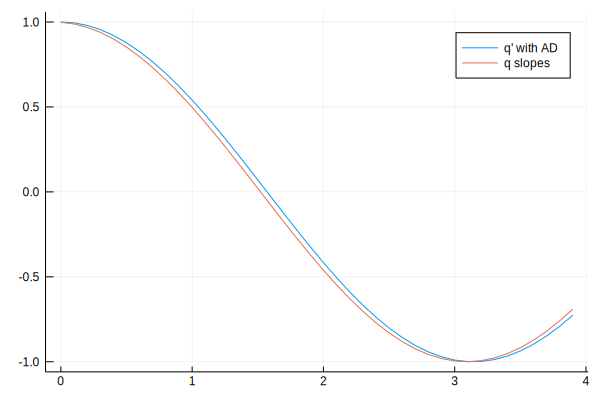

In [50]:
using Plots, ForwardDiff

# para obter a derivada dessa função usando AD
D(f) = x -> ForwardDiff.derivative(f, x)

# comparar inclinações com AD para sin (x)
q(x) = sin(x)
x = 0.0:0.1:4.0
q_x = q.(x)
q_slopes_x = slopes(q_x, x)

D_q_x = D(q).(x)  

plot(x[1:end-1], D_q_x[1:end-1], label = "q' with AD")
plot!(x[1:end-1], q_slopes_x, label = "q slopes")

Considere uma variação na qual passamos uma função em vez de uma `AbstractArray`.

In [51]:
slopes(f::Function, x::AbstractRange) = diff(f.(x)) / step(x)  # broadcast function

@show typeof(q) <: Function
@show typeof(x) <: AbstractRange
q_slopes_x = slopes(q, x)  # use slopes(f::Function, x)
@show q_slopes_x[1];

typeof(q) <: Function = true
typeof(x) <: AbstractRange = true
q_slopes_x[1] = 0.9983341664682815


Finalmente, se `x` foi um `AbstractArray` e não um `AbstractRange` não podemos mais usar um passo uniforme.

Para isso, adicionamos em uma versão o cálculo de inclinações com as primeiras diferenças.

In [52]:
# transmite sobre o diff
slopes(f::Function, x::AbstractArray) = diff(f.(x)) ./ diff(x)

x_array = Array(x)  # converte o intervalo em matriz
@show typeof(x_array) <: AbstractArray
q_slopes_x = slopes(q, x_array)
@show q_slopes_x[1];

typeof(x_array) <: AbstractArray = true
q_slopes_x[1] = 0.9983341664682815


No exemplo final, vemos que ele é capaz de usar implementações especializadas sobre ambos a `f` os argumentos `x`.

Este é o "múltiplo" no despacho múltiplo.

## Exercícios

### Exercício 1

Explore o pacote [StaticArrays.jl](https://github.com/JuliaArrays/StaticArrays.jl).

- Descreva dois tipos abstratos e a hierarquia de três tipos concretos diferentes. 
- Compare o cálculo de uma álgebra linear simples com uma matriz estática em comparação com o seguinte para uma matriz densa para `N = 3`e`N = 15`.

In [53]:
using BenchmarkTools

N = 3
A = rand(N, N)
x = rand(N)

@btime $A * $x  # o $ na frente dos nomes das variáveis às vezes é importante
@btime inv($A)

  80.999 ns (1 allocation: 112 bytes)
  711.014 ns (5 allocations: 1.98 KiB)


3×3 Array{Float64,2}:
 -1.98485   -1.39279    3.72538 
  4.54179    0.650274  -2.83779 
 -0.321769   1.06666    0.118773

### Exercício 2

Uma etapa importante no cálculo do filtro Kalman é o cálculo do ganho de Kalman, como pode ser visto no exemplo a seguir, usando matrizes densas da [aula Kalman](https://julia.quantecon.org/tools_and_techniques/kalman.html).

Usando o que você aprendeu no exercício 1, faca um benchmark usando matrizes estáticas.

In [54]:
Σ = [0.4  0.3;
     0.3  0.45]
G = I
R = 0.5 * Σ

gain(Σ, G, R) = Σ * G' * inv(G * Σ * G' + R)
@btime gain($Σ, $G, $R)

  794.184 ns (10 allocations: 1.94 KiB)


2×2 Array{Float64,2}:
 0.666667     1.11022e-16
 1.11022e-16  0.666667   

Quantas vezes mais rápido são matrizes estáticas neste exemplo?

### Exercise 3

O [Polynomial.jl](https://github.com/JuliaMath/Polynomials.jl) fornece um pacote para simples polinômios univariados.

In [55]:
using Polynomials

p = Poly([2, -5, 2], :x)  # :x dá apenas um símbolo para exibição 

@show p
p′ = polyder(p)   # dá a derivada de p, um outro polinómio 
@show p(0.1), p′(0.1)  # chama como uma função
@show roots(p);   # encontre raízes tais que p(x) = 0

p = Poly(2 - 5*x + 2*x^2)
(p(0.1), p′(0.1)) = (1.52, -4.6)
roots(p) = [0.5, 2.0]


Plote ambos `p(x)` e `p′(x)` para $ x \in [-2, 2] $.

### Exercício 4

Use sua solução do exercício 8 (a/b) em [Exemplos Introdutórios](https://julia.quantecon.org/getting_started_julia/julia_by_example.html) para criar uma versão especialida do método de Newton  para `Polinômioss` usando a função `polyder`. 

A assinatura da função deve ser `newtonsmethod(p::Poly, x_0; tolerance = 1E-7, maxiter = 100)`,
onde `p::Poly` garante que esta versão da função seja usada sempre que um polinômio for passado (por exemplo, despacho).

Compare os resultados desta função com a função interna `roots(p)`.


<a id='intro-types-ex-5'></a>

### Exercício 5 (Avançado)

A [regra trapezoidal](https://en.wikipedia.org/wiki/Trapezoidal_rule)  aproxima uma integral com:

$$
\int_\underline{x}^\bar{x} f(x) \, dx \approx \sum_{n=1}^N \frac{f(x_{n-1}) + f(x_n)}{2} \Delta x_n
$$

Onde $ x_0 = \underline{x},\, x_N = \bar{x} $, e $ \Delta x_n \equiv x_{n-1} - x_n $

Para um `x` e uma função `f`, implemente poucas variações da regra do trapezoidal usando múltiplos despachos:

- `trapezoidal(f, x)` para algum `typeof(x) = AbstractArray` e `typeof(f) == AbstractArray` onde `length(x) = length(f)`.  
- `trapezoidal(f, x)` para algum `typeof(x) = AbstractRange` e `typeof(f) == AbstractArray` onde `length(x) = length(f)`.
  * Explorar o fato de que no `AbstractRange` existem tamanhos de etapa constantes para especializar o algoritmo.
- `trapezoidal(f, x̲, x̄, N)` onde `typeof(f) = Function`, e os outros argumentos são `Real`
  * Para isso, crie um *grid* uniforme com `N` pontos em `[x̲, x̄]` – chame a função `f`  nesses pontos de *grid* e use a existente `trapezoidal(f, x)` para a implementação  


Com estas:
1. Teste cada variação da função com  $ f(x) = x^2 $ com $ \underline{x}=0,\, \bar{x} = 1 $.
2. Na solução analítica da função, plote o erro de `trapezoidal(f, x̲, x̄, N)` relativo à solução analítica para um *grid* de `N` valores diferentes.
3. Considere tentar funções diferentes para $ f(x) $ e compare as soluções para as vários `N`.

Ao tentar funções diferentes, em vez de integrar manualmente, considere usar um pacote da biblioteca de alta precisão para integração numérica como [QuadGK.jl](https://juliamath.github.io/QuadGK.jl/latest/).

In [56]:
using QuadGK

f(x) = x^2
value, accuracy = quadgk(f, 0.0, 1.0)

(0.3333333333333333, 5.551115123125783e-17)

### Exercício 6 (Avançado)

Faça uma variação do seu código no Exercício 5.

Use a diferenciação automática para calcular a derivada a seguir para as funções:

$$
\frac{d}{d \bar{x}}\int_\underline{x}^\bar{x} f(x) \, dx
$$

Dica: Veja o código a seguir para o padrão geral e tome cuidado para seguir as [regras de programação genérica](#generic-tips-tricks).

In [57]:
using ForwardDiff

function f(a, b; N = 50)
    r = range(a, b, length=N) # um
return mean(r)
end

Df(x) = ForwardDiff.derivative(y -> f(0.0, y), x)

@show f(0.0, 3.0)
@show f(0.0, 3.1)

Df(3.0)

f(0.0, 3.0) = 1.5
f(0.0, 3.1) = 1.55


0.5